# Import the necessary libraries, dataset



In [1]:
# Buiding a NN model
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Doanloading the training ata from open datasets
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:07<00:00, 3.61MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


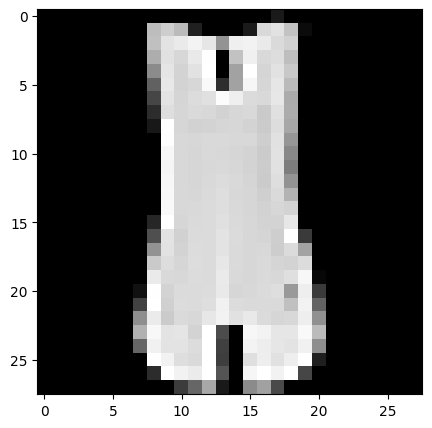

0


In [71]:
# Access the first image with its label
image, label = training_data[4]


%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(image.squeeze(), cmap = 'gray')
plt.show()
print(label)

In [3]:
# Doanload the test data from open datasets
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

In [4]:
# Define the batch size
batch_size = 64

# Create data loaders

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Creating models
# Accelerator usage
device = torch.accelerator.current_accelerator().type\
if torch.accelerator.is_available() else "cpu"

print("Device: {device}")

Device: {device}


# Define the model architecture

In [17]:
# Define the model

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Optimizing the model parameters**

In [18]:
loss_function = nn.CrossEntropyLoss()# Define the loss function which will drive the optimization
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)#the optimizer which takes the loss information and updates the weight
# Loss function -> Gradients -> Weights adjustments

# Define the 'Train' method

In [19]:
def train(dataloader, model, loss_function, optimizer):
  size = len(dataloader.dataset)# Size of the training dataset
  model.train()# Train the model
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    prediction = model(X)
    loss = loss_function(prediction, y)

    # Backpropagation
    loss.backward()# Calculate the gradients and attach it to .grad attribute for each parameter
    optimizer.step()# Optimizer has access to params # Update the weights of the model
    optimizer.zero_grad()# Reset the gradients to 0 so the gradients from prev. iteration dont accumulate

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1)* len(X)
      print(f"loss:{loss:>7f} [{current:>5d}/{size:.>5d}]")


# Define the 'Test' method

In [24]:
def test(dataloader, model, loss_function):
  size = len(dataloader.dataset)
  num_of_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      predictions = model(X)
      test_loss += loss_function(predictions, y).item()
      correct += (predictions.argmax(1) == y). type(torch.float).sum().item()
  test_loss /= num_of_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100* correct):>0.1}%, Avg loss: {test_loss:>8f} \n")


# Train the model

In [26]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1} \n---------")
  train(train_dataloader, model, loss_function, optimizer)
  test(test_dataloader, model, loss_function)
print("Done")

Epoch 1 
---------
loss:0.939665 [   64/60000]
loss:0.999303 [ 6464/60000]
loss:0.773960 [12864/60000]
loss:0.949193 [19264/60000]
loss:0.822881 [25664/60000]
loss:0.846994 [32064/60000]
loss:0.917360 [38464/60000]
loss:0.878595 [44864/60000]
loss:0.909832 [51264/60000]
loss:0.841635 [57664/60000]
Test Error: 
 Accuracy: 7e+01%, Avg loss: 0.855471 

Epoch 2 
---------
loss:0.871148 [   64/60000]
loss:0.948569 [ 6464/60000]
loss:0.712599 [12864/60000]
loss:0.901507 [19264/60000]
loss:0.781702 [25664/60000]
loss:0.794600 [32064/60000]
loss:0.876550 [38464/60000]
loss:0.841938 [44864/60000]
loss:0.868080 [51264/60000]
loss:0.805104 [57664/60000]
Test Error: 
 Accuracy: 7e+01%, Avg loss: 0.815682 

Epoch 3 
---------
loss:0.815977 [   64/60000]
loss:0.907261 [ 6464/60000]
loss:0.664734 [12864/60000]
loss:0.864079 [19264/60000]
loss:0.750808 [25664/60000]
loss:0.754199 [32064/60000]
loss:0.842961 [38464/60000]
loss:0.814320 [44864/60000]
loss:0.835232 [51264/60000]
loss:0.775594 [57664/6000

# Save the trained model

In [29]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch model state to model.pth")

Saved PyTorch model state to model.pth


# Load the Pre-trained model

In [35]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only = True))

<All keys matched successfully>

# Make the predictions on the new data

In [36]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
